In [1]:
from src.utils.hr_bpe.src.bpe import HRBPE
from src.utils.hr_bpe.src.utils import get_spans, eval_segmentation
from src.utils.data import load_ud
from collections import defaultdict
from collections import Counter
from tqdm import tqdm
import numpy as np
import os, re, json

print("Loading gold-tagged UDs data...")
load_set = "GUM"; space = True; max_char = 200_000_000; num_external = 1000; seed = 691; language = "English"
all_docs = load_ud(language, num_articles = 0, seed = seed, load_set = load_set, rebuild = True, space = space)
test_docs = [doc for doc in all_docs if 'test' in doc['id'] and len(doc['text']) <= max_char] # [:2]
train_docs = [doc for doc in all_docs if 'test' not in doc['id'] and len(doc['text']) <= max_char] # [:4]
print("Loading external training data...")
external_path = '/data/newstweet/week_2019-40_article_texts/'
total_external = len([external_file for external_file in os.listdir(external_path) if re.search("^\d+.txt$", external_file)])
all_external_files = [external_file for external_file in os.listdir(external_path) if re.search("^\d+.txt$", external_file)]
num_external = min([num_external, len(all_external_files)]) if language == "English" else 0 ## possibly force external data to zero
if num_external:
    np.random.seed(seed)
    external_files = np.random.choice(all_external_files, size=num_external, replace=False)
else:
    external_files = np.array([])
exdocs = [open(external_path+external_file).read() for external_file in tqdm(external_files)]
print('Avail. external, total external, Avail. gold, total gold-train, total test-gold: ', 
      total_external, len(exdocs), len(all_docs), len(train_docs), len(test_docs))

Loading gold-tagged UDs data...
Loading external training data...


100%|██████████| 1000/1000 [00:14<00:00, 71.29it/s]

Avail. external, total external, Avail. gold, total gold-train, total test-gold:  14198 1000 150 132 18


In [2]:
method = 'hr-bpe'
init_method = 'char'
num_batches = 100
batch_size = 10_000
actions_per_batch = int(batch_size/1)
reg_model = 'mixing'
param_method = 'est_theta'
early_stop = True
use_cover = False
use_covering_vocab = True
#####

docs = ["".join(["".join([row[1] for row in s]) for s in d['conllu']]) for d in train_docs]
tdocs = ["".join(["".join([row[1] for row in s]) for s in d['conllu']]) for d in test_docs]
covering = [[row[1] for s in d['conllu'] for row in s] for d in train_docs] if use_cover else []
tcovering = [[row[1] for s in d['conllu'] for row in s] for d in test_docs]
covering_vocab = set([t for d in [[[row[1] for row in s] for s in d['conllu']] for d in train_docs] for s in d for t in s]) if use_covering_vocab else set()
model_str = f'{method}_{init_method}_{num_batches}_{batch_size}_{actions_per_batch}_{reg_model}_{param_method}_{language}_{seed}_{load_set}-{num_external}'
if num_external: docs = docs + exdocs

print('model name: ', model_str, '\n')
print('number of samples, total characters, covering vocabulary size: ', len(docs), sum([len(d) for d in docs]), len(covering_vocab))

model name:  hr-bpe_char_100_10000_10000_mixing_est_theta_English_691_GUM-1000 

number of samples, total characters, covering vocabulary size:  1132 3938066 15028


In [3]:
docs[0][:50]

' Introduction  Research on adult-learned second la'

In [4]:
model = HRBPE(param_method=param_method, reg_model=reg_model, early_stop=early_stop, covering_vocab = covering_vocab) 
model.init(docs, seed=seed, method=init_method, covering = covering,
           action_protect = ["\n","[*\(\{\[\)\}\]\.\?\!\,\;][ ]*\w", "\w[ ]*[*\(\{\[\)\}\]\.\?\!\,\;]"])
model.fit(num_batches, batch_size, actions_per_batch=actions_per_batch, seed=seed)

Fitting:  17%|█▋        | 17/100 [06:24<31:18, 22.64s/it]


Built a vocabulary of 43213 types


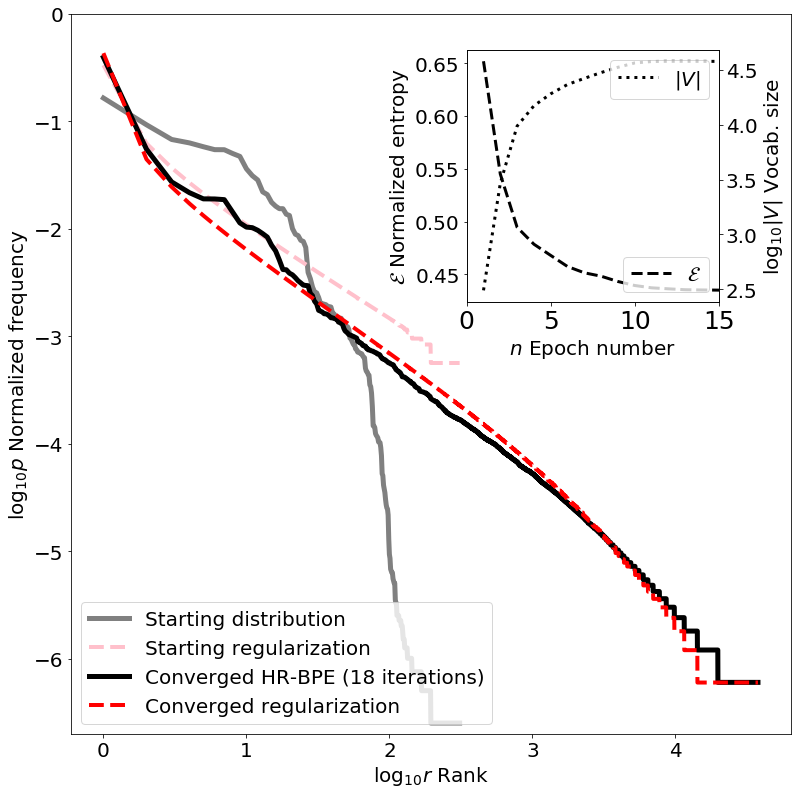

In [5]:
model.display_epochs(fname = 'img/' + model_str + '.png')

In [6]:
model.save('cache/' + model_str + '.json')

In [7]:
mod = HRBPE(param_method=param_method, reg_model=reg_model, early_stop=early_stop)
data = mod.load('cache/' + model_str + '.json')
mod.init([], seed=seed, method=init_method)
print("P, R, F1: ", list(map(np.mean, zip(*[eval_segmentation(ts, mod.tokenize("".join(ts))) for ts in tqdm(tcovering) if ts]))))

Initializing: 0it [00:00, ?it/s]
100%|██████████| 18/18 [00:11<00:00,  1.57it/s]

P, R, F1:  [0.712509677539077, 0.8652726112472374, 0.7810276812050239]


In [8]:
import json
from src.utils.hr_bpe.src.bpe import BPE, load_td, listokenize

td = load_td(path = 'cache/' + model_str + '.json')
listokenize("How's it going over there today?", td)

('How',
 "'s",
 ' ',
 'it',
 ' ',
 'going',
 ' ',
 'over',
 ' ',
 'the',
 'r',
 'e',
 ' ',
 'today',
 '?')